In [6]:
# !pip install numpy --upgrade
!pip install backoff
!git clone https://github.com/solpaul/fpl-prediction.git
%cd fpl-prediction/
from fpl_predictor.util import *

Cloning into 'fpl-prediction'...
remote: Enumerating objects: 86070, done.
remote: Counting objects: 100% (10532/10532), done.
remote: Compressing objects: 100% (6181/6181), done.
remote: Total 86070 (delta 3847), reused 9346 (delta 3342), pack-reused 75538
Receiving objects: 100% (86070/86070), 135.43 MiB | 16.89 MiB/s, done.
Resolving deltas: 100% (39518/39518), done.
Checking out files: 100% (7269/7269), done.
/content/fpl-prediction


In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)
print(np.__version__)

# from numpy.lib.stride_tricks import sliding_window_view

2.5.0
1.19.5


In [8]:
!nvidia-smi

Fri Aug  6 15:41:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 13.6 gigabytes of available RAM



In [10]:
# path to project directory
path = Path('./')

# read in training dataset
train_df = pd.read_csv(path/'fpl_predictor/data/train_v8.csv', 
                       index_col=0, 
                       dtype={'season':str,
                              'squad':str,
                              'comp':str})

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114801 entries, 0 to 114802
Data columns (total 59 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   player                                      114801 non-null  object 
 1   gw                                          114801 non-null  int64  
 2   position                                    114801 non-null  int64  
 3   minutes                                     114801 non-null  int64  
 4   team                                        114801 non-null  object 
 5   opponent_team                               114801 non-null  object 
 6   relative_market_value_team                  46738 non-null   float64
 7   relative_market_value_opponent_team         46715 non-null   float64
 8   was_home                                    114801 non-null  bool   
 9   total_points                                114801 non-null  int64  
 

In [ ]:
# some players with the same names and after transfers causing duplicates
# delete them for now
train_df = train_df[~((train_df['player'] == 'Ben Davies') & (train_df['team'] == 'Liverpool'))]
# train_df = train_df[~((train_df['player'] == 'Dale Stephens') & (train_df['kickoff_time'] == '2020-09-20T13:00:00Z'))]
# train_df = train_df[~((train_df['player'] == 'Ross Barkley') & (train_df['kickoff_time'] == '2020-09-26T16:30:00Z'))]

In [ ]:
# can try only using data when xg/xa is available
# still seems to do better with the additional incomplete data, but getting marginal
# train_df = train_df[train_df['season'] != '1617']

In [ ]:
train_df.shape

(114784, 59)

In [ ]:
train_df[train_df.duplicated(subset=['date','player','team'], keep=False)]

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba,relative_market_value_team_season,relative_market_value_opponent_team_season,date,squad,comp,shots_total,shots_on_target,touches,pressures,tackles,interceptions,blocks,xg,npxg,xa,sca,gca,passes_completed,passes,passes_pct,carries,dribbles_completed,dribbles,crowds


In [ ]:
sum(train_df.duplicated(subset=['date','player','team'], keep=False))

0

In [ ]:
# enhanced stats are NA if the player didn't have any minutes in the match
# also NA for 16/17 season
# set all these to 0
train_df[['xg', 'xa']] = train_df[['xg', 'xa']].fillna(0)

# one-hot categorical variables
train_df['s'] = train_df['season']
train_df = pd.get_dummies(train_df, columns=['position', 's'])

train_df

,player,gw,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba,relative_market_value_team_season,relative_market_value_opponent_team_season,date,squad,comp,shots_total,shots_on_target,touches,pressures,tackles,interceptions,blocks,xg,npxg,xa,sca,gca,passes_completed,passes,passes_pct,carries,dribbles_completed,dribbles,crowds,position_1,position_2,position_3,position_4,s_1617,s_1718,s_1819,s_1920,s_2021
0,Aaron Cresswell,1,0,West Ham United,Chelsea,NaN,NaN,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,14023,1,2,0.0,0,0,0,0,2016-08-15T19:00:00Z,1617,NaN,0.895471,2.243698,2016-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,1,0,0,1,0,0,0,0
1,Aaron Lennon,1,15,Everton,Tottenham Hotspur,NaN,NaN,True,1,0,0,6,0,0.3,0,0,0.9,8.2,0,0,0,0,0,13918,1,1,0.0,0,0,0,0,2016-08-13T14:00:00Z,1617,NaN,1.057509,1.433690,2016-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,0,1,0,1,0,0,0,0
2,Aaron Ramsey,1,60,Arsenal,Liverpool,NaN,NaN,True,2,0,0,5,0,4.9,3,0,3.0,2.2,0,0,0,0,0,163170,4,3,23.0,0,0,0,0,2016-08-14T15:00:00Z,1617,NaN,1.944129,1.465860,2016-08-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,0,1,0,1,0,0,0,0
3,Abdoulaye Doucouré,1,0,Watford,Southampton,NaN,NaN,False,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1051,1,1,0.0,0,0,0,0,2016-08-13T14:00:00Z,1617,NaN,0.704200,0.796805,2016-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,0,1,0,1,0,0,0,0
4,Abdul Rahman Baba,1,0,Chelsea,West Ham United,NaN,NaN,True,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1243,1,2,0.0,0,0,0,0,2016-08-15T19:00:00Z,1617,NaN,2.243698,0.895471,2016-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114798,Aaron Ramsdale,38,90,Sheffield United,Burnley,0.312126,0.307548,True,9,0,2,30,1,10.0,0,0,3.2,22.0,0,0,0,0,3,162985,0,1,0.0,13618,17381,3763,0,2021-05-23T15:00:00Z,2021,1.0,0.361923,0.344836,2021-05-23,Sheffield United,Premier League,0.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,19.0,41.0,46.3,18.0,0.0,0.0,True,1,0,0,0,0,0,0,0,1
114799,Adrien Silva,38,0,Leicester City,Tottenham Hotspur,1.165630,1.568259,True,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,16396,4,2,0.0,-16,0,16,0,2021-05-23T15:00:00Z,2021,0.0,1.029069,1.694101,2021-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,0,1,0,0,0,0,0,1
114800,Sidnei Tavares,38,0,Leicester City,Tottenham Hotspur,1.165630,1.568259,True,0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,337,4,2,0.0,32,60,28,0,2021-05-23T15:00:00Z,2021,1.0,1.029069,1.694101,2021-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0,0,1,0,0,0,0,0,1
114801,Kalvin Phillips,38,90,Leeds,West Bromwich Albion,0.515553,0.276793,True,6,0,0,17,0,12.8,1,1,6.1,40.6,0,0,0,0,0,74008,1,3,8.0,210,789,579,1,2021-05-23T15:00:00Z,2021,1.0,0.300409,0.185012,2021-05-23,Leeds,Premier League,2.0,1.0,70.0,37.0,5.0,1.0,4.0,0.0,0.0,0.0,2.0,0.0,39.0,47.0,83.0,48.0,1.0,4.0,True,0,0,1,0,0,0,0,0,1


In [ ]:
valid_season = '2021'
valid_gw = 20
valid_len = 6

identifiers = ['player', 'team', 'season', 'gw', 'kickoff_time']

cont_vars = ['minutes',
             #'total_points_team', 'goals_scored', 
             'xg', 'xa', 
             'xg_team', 'xg_team_conceded']#,
            # 'goals_scored_team', 'goals_scored_team_conceded']

cat_vars = ['position_1', 'position_2', 'position_3', 'position_4', 
            's_1617', 
            's_1718', 's_1819', 's_1920', 's_2021',
            'was_home']

# could try adding gw in some way
# may adapt better to different stages of season

next_vars = ['next_was_home']#'next_minutes']

features_opponent = [
                    #  'total_points_team_pg_last_all_opponent',
                    #  'total_points_team_pg_last_10_opponent',
                    #  'total_points_team_pg_last_4_opponent',
                    #  'total_points_team_pg_last_2_opponent',
                    #  'total_points_team_conceded_pg_last_10_opponent',
                    #  'total_points_team_conceded_pg_last_20_opponent',
                    #  'goals_scored_team_pg_last_10_opponent', 
                    #  'goals_scored_team_pg_last_20_opponent',
                    #  'goals_scored_team_conceded_pg_last_10_opponent', 
                    #  'goals_scored_team_conceded_pg_last_20_opponent',
                     'xg_team_pg_last_10_opponent', 
                     'xg_team_pg_last_20_opponent',
                     'xg_team_conceded_pg_last_10_opponent',
                     'xg_team_conceded_pg_last_20_opponent'
                     ]
# adding opponent goals scored seems to help it converge very quickly (not quite as good)

features_next_opponent = ['next_' + x for x in features_opponent]

dep_var = ['total_points']

fields = cont_vars + cat_vars + next_vars + features_opponent + features_next_opponent + dep_var
dims = len(fields)

# lag points needed for opponent
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points', 'goals_scored', 'xg'], [10, 20])#'all', 10, 4, 2])

In [ ]:
# dataset with adjusted post-validation lag numbers
train_valid_df, train_idx, valid_idx = create_lag_train(lag_train_df, cat_vars + identifiers, cont_vars, 
                                                        [], features_opponent, dep_var,
                                                        valid_season, valid_gw, valid_len)

# new teams as opposition have NA, replace with 0
train_valid_df[features_opponent] = train_valid_df[features_opponent].fillna(0)

# add season match numbers for players
train_valid_df = train_valid_df.sort_values(['kickoff_time', 'team'])
train_valid_df['season_match_no'] = train_valid_df.groupby(['player', 'season'])['kickoff_time'].apply(lambda x: (~pd.Series(x).duplicated()).cumsum())

# combine with season to get overall match numbers
train_valid_df['overall_match_no'] = train_valid_df['season'] + [str(x).zfill(2) for x in train_valid_df['season_match_no']]

# at some point I really should try normalising the continuous variables

In [ ]:
def flattened_dataframes(df, fields, features_opponent, features_next_opponent, 
                         valid_season, valid_gw):

    # training set is everything up to (and including) validation gw
    train_base = df.copy()[(df['season'] < valid_season) | 
                           ((df['season'] == valid_season) &
                            (df['gw'] < valid_gw))]

    train = train_base.copy()

    # add next gameweek's minutes
    # NOT DOING THIS ANYMORE
    # train['next_minutes'] = (train.groupby(['player'])['minutes']
    #                                 .apply(lambda x: x.shift(-1)
    #                                 .rolling(1, min_periods = 0).sum()))

    # add next gameweek's was_home
    train['next_was_home'] = (train.groupby(['player'])['was_home']
                              .apply(lambda x: x.shift(-1)
                              .rolling(1, min_periods = 0).sum()))

    # add next opponent stats
    for feature, feature_next in zip(features_opponent, features_next_opponent):
        train[feature_next] = (train.groupby(['player'])[feature]
                                    .apply(lambda x: x.shift(-1)
                                    .rolling(1, min_periods = 0).sum()))

    # one row of data for each player
    train = train.set_index(['player', 'overall_match_no']).unstack()[fields]


    # for validation we'll loop through each kickoff time
    valid_df = df.copy()[(df['season'] == valid_season) & 
                         (df['gw'] >= valid_gw)]

    valid_kickoffs = valid_df['kickoff_time'].unique()

    valid = []

    for kickoff in valid_kickoffs:
        # for each kickoff time we take all the players
        valid_rows = valid_df[valid_df['kickoff_time'] == kickoff]
        valid_players = valid_rows['player'].unique()

        # we want all previous data from the train portion for each player
        train_rows = train_base[train_base['player'].isin(valid_players)]

        # concat the valid and train portions
        combined = train_rows.append(valid_rows, ignore_index=True)

        # add next gameweek's minutes
        # NOT DOING THIS ANYMORE
        # combined['next_minutes'] = (combined.groupby(['player'])['minutes']
        #                             .apply(lambda x: x.shift(-1)
        #                             .rolling(1, min_periods = 0).sum()))

        # add next gameweek's was_home
        combined['next_was_home'] = (combined.groupby(['player'])['was_home']
                                  .apply(lambda x: x.shift(-1)
                                  .rolling(1, min_periods = 0).sum()))

        # add next opponent stats
        for feature, feature_next in zip(features_opponent, features_next_opponent):
            combined[feature_next] = (combined.groupby(['player'])[feature]
                                .apply(lambda x: x.shift(-1)
                                .rolling(1, min_periods = 0).sum()))

        # now add flattened version to list
        valid.append(combined.set_index(['player', 'overall_match_no']).unstack()[fields])

    # concat all to get the validation set
    # we will only take one sequence of the last window_size per row
    valid = pd.concat(valid)

    # make sure it is in the right order
    valid = valid[fields]

    return train, valid

In [ ]:
train, valid = flattened_dataframes(train_valid_df, fields, features_opponent, 
                                    features_next_opponent, valid_season, valid_gw)

print(train.shape)
print(train)
print(train.iloc[1])

    
print(valid.shape)
print(valid)
print(valid.iloc[5])

(1450, 4275)
                 minutes                       ... total_points                     
overall_match_no  161701 161702 161703 161704  ...       202116 202117 202118 202119
player                                         ...                                  
Aaron Connolly       NaN    NaN    NaN    NaN  ...          0.0    5.0    0.0    0.0
Aaron Cresswell      0.0    0.0    0.0    0.0  ...          6.0   11.0    8.0    2.0
Aaron Lennon        15.0    0.0    0.0    0.0  ...          NaN    NaN    NaN    NaN
Aaron Mooy           NaN    NaN    NaN    NaN  ...          0.0    0.0    0.0    0.0
Aaron Ramsdale       0.0    NaN    NaN    NaN  ...          2.0    1.0    9.0    1.0
...                  ...    ...    ...    ...  ...          ...    ...    ...    ...
Álvaro Arbeloa       0.0    0.0   90.0   84.0  ...          NaN    NaN    NaN    NaN
Álvaro Morata        NaN    NaN    NaN    NaN  ...          NaN    NaN    NaN    NaN
Álvaro Negredo      90.0   90.0   90.0   90.0  ...  

In [ ]:
 # add columns for minutes shifted back once
# gameweeks = valid.shape[1]//dims
# valid_shifted = valid.iloc[:,:gameweeks].shift(-1,axis=1)
# valid_shifted.iloc[:,-1] = valid_shifted.iloc[:,-2]
# valid = pd.concat([valid, valid_shifted], axis=1)

In [ ]:
for column in valid.columns.get_level_values(0).unique():
    print(column + " - " + str(len(valid.iloc[0][column].dropna())))


minutes - 172
xg - 172
xa - 172
xg_team - 172
xg_team_conceded - 172
position_1 - 172
position_2 - 172
position_3 - 172
position_4 - 172
s_1617 - 172
s_1718 - 172
s_1819 - 172
s_1920 - 172
s_2021 - 172
was_home - 172
next_was_home - 172
xg_team_pg_last_10_opponent - 172
xg_team_pg_last_20_opponent - 172
xg_team_conceded_pg_last_10_opponent - 172
xg_team_conceded_pg_last_20_opponent - 172
next_xg_team_pg_last_10_opponent - 172
next_xg_team_pg_last_20_opponent - 172
next_xg_team_conceded_pg_last_10_opponent - 172
next_xg_team_conceded_pg_last_20_opponent - 172
total_points - 172


In [ ]:
# for column in valid.columns.get_level_values(0).unique():
#     print(column + " - " + str(len(valid.loc['Emiliano Martínez'][column].iloc[0].dropna())))


In [ ]:
# need to reshape into no of weeks x no of fields 
for row in valid[3:4].iterrows():
        one_player = row[1].to_numpy()

        # couldn't figure how to do this with reshape or similar
        # so just loop through and stack
        length = len(one_player)//(dims)
        array = [one_player[i*length:(i+1)*length] for i in range(dims)]
        array = np.stack(array, axis=1)
        print(array[155:])
        print(array.shape)




[[0.0 0.0 0.0 1.5 0.4 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 False 0.0
  1.7799999999999994 1.605000000000001 1.07 1.1050000000000002
  1.430000000000002 1.3899999999999995 1.0199999999999998
  1.4649999999999979 0.0]
 [0.0 0.0 0.0 2.1 1.2 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 False 1.0
  1.430000000000001 1.389999999999999 1.0199999999999998
  1.4650000000000003 2.480000000000001 2.3599999999999994
  0.9899999999999991 0.9499999999999971 0.0]
 [0.0 0.0 0.0 0.5 0.8999999999999999 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0
  True 0.0 2.48 2.359999999999999 0.9899999999999993 0.9499999999999996
  2.2000000000000015 1.9550000000000005 1.4000000000000004
  1.3049999999999975 0.0]
 [0.0 0.0 0.0 0.4 1.8 0.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 1.0 False 1.0 2.2
  1.9549999999999996 1.4000000000000008 1.305 0.9400000000000013
  1.015000000000001 1.5899999999999985 1.6899999999999975 0.0]
 [0.0 0.0 0.0 1.4000000000000001 1.5000000000000002 0.0 0.0 0.0 1.0 0.0
  0.0 0.0 0.0 1.0 True 0.0 0.9400000000000001 1.0150000

In [ ]:
array.shape

(178, 25)

In [ ]:
# beware duplicates...
# lag_train_df[lag_train_df.duplicated(subset=['player', 'overall_match_no'], keep=False)].head(10)

In [ ]:
# create windows for each player
# window_size long sequences of vectors
window_size = 38
batch_size = 64
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(df, dims, window_size, batch_size, shuffle_buffer_size, 
                     valid=False, valid_len=None):

    players = []

    for row in df.iterrows():
        # remove NaNs (most players haven't played maximum possible games)
        # (also need to remove validation NAs)
        one_player = row[1].dropna().to_numpy().astype(float)
        assert(len(one_player) % dims == 0)
        length = len(one_player)//dims   
        one_player = np.stack([one_player[i*length:(i+1)*length] for i in range(dims)], axis=1)

        # pad with zeros to front of sequence
        one_player = np.vstack((np.tile([0]*dims, (window_size, 1)), one_player))
        
        # create window sequence indexer (split by 1)
        indexer = np.arange(window_size + 1)[None, :] + np.arange(len(one_player) - window_size)[:, None]

        # add to list
        if valid:
            # for validation we only want the final sequence
            # also only rows where final minutes value is not 0 NOT DOING THIS ANYMORE
            sequences = np.expand_dims(one_player[-window_size - 1:], axis=0)
            # mask = sequences[:,-1,0] != 0
            # players.append(sequences[mask])
            players.append(sequences)
        else:
            # for train we want all sequences
            players.append(one_player[indexer])

    # concatenate all the sequences and add a dimension
    ds = np.concatenate(players)

    # check the shape, should be (n, window_size + 1, dims)
    assert(ds.shape[1] == window_size + 1)
    assert(ds.shape[2] == dims)

    # create dataset
    ds = tf.data.Dataset.from_tensor_slices(ds)

    # shuffle it if in train
    if valid == False:
        ds = ds.shuffle(shuffle_buffer_size)

    # create input and label sequences
    # label is just the last element (total_points)
    # both of length window_size, separated by 1
    ds = ds.map(lambda w: (w[:-1], w[1:,-1]))

    # this version removes total points from the input sequences
    # ds = ds.map(lambda w: (w[:-1,:-1], w[1:,-1]))
    
    return ds.batch(batch_size).prefetch(1)

In [ ]:
ds_valid = windowed_dataset(valid[:1], dims, window_size, batch_size, shuffle_buffer_size,
                            valid=True, valid_len=valid_len)

In [ ]:
ds_train = windowed_dataset(train[:1], dims, window_size, batch_size, shuffle_buffer_size)

In [ ]:
ds_train = windowed_dataset(train, dims, window_size, batch_size, shuffle_buffer_size)
ds_valid = windowed_dataset(valid, dims, window_size, batch_size, shuffle_buffer_size,
                            valid=True, valid_len=valid_len)

# sequences = ds_train.take(1)

# for input, label in sequences:
#     print(input)
#     print(label)


labels = []
for _, label in ds_valid:
    labels.extend(label[:,-1])

labels = np.array(labels)
labels.shape

(4164,)

In [ ]:
# we need a custom validation metric
# only takes last output (i.e. the gw after the last in the sequence)
class MaeLast(tf.keras.metrics.Metric):

    def __init__(self, name='mae_last', **kwargs):
        super(MaeLast, self).__init__(name=name, **kwargs)
        self.mae_last = self.add_weight(name='mae_last')
        self.m = tf.keras.metrics.MeanAbsoluteError()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true[:,-1]
        y_pred = y_pred[:,-1]
        self.mae_last.assign(self.m(y_true, y_pred))

    def result(self):
        return self.mae_last

In [ ]:
class RmseLast(tf.keras.metrics.Metric):

    def __init__(self, name='rmse_last', **kwargs):
        super(RmseLast, self).__init__(name=name, **kwargs)
        self.rmse_last = self.add_weight(name='rmse_last')
        self.m = tf.keras.metrics.RootMeanSquaredError()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true[:,-1]
        y_pred = y_pred[:,-1]
        self.rmse_last.assign(self.m(y_true, y_pred))

    def result(self):
        return self.rmse_last

In [ ]:
# instatiate the validation metric
metric = RmseLast()

# early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_rmse_last', 
                                                  patience=5,
                                                  restore_best_weights=True)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
#   tf.keras.layers.Conv1D(filters=32, kernel_size=5,
#                       strides=1, padding="causal",
#                       activation="relu",
#                       input_shape=[None, dims]),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 20)
])

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-4 * 0.5**(epoch / 3))
# optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9) 
# try adam
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5) 

model.compile(
    # loss=tf.keras.losses.Huber(),
    loss=tf.keras.losses.MeanSquaredError(),
              optimizer=optimizer,
              metrics=[metric])
history = model.fit(ds_train, epochs=100, validation_data=ds_valid,
                    callbacks=[early_stopping])#, callbacks=[lr_schedule])


Epoch 1/100
1586/1586 [==============================] - 16s 9ms/step - loss: 4.1926 - rmse_last: 2.2239 - val_loss: 4.2929 - val_rmse_last: 2.1741
Epoch 2/100
1586/1586 [==============================] - 13s 8ms/step - loss: 4.0080 - rmse_last: 2.1678 - val_loss: 4.2426 - val_rmse_last: 2.1601
Epoch 3/100
1586/1586 [==============================] - 14s 9ms/step - loss: 3.9641 - rmse_last: 2.1557 - val_loss: 4.2086 - val_rmse_last: 2.1500
Epoch 4/100
1586/1586 [==============================] - 13s 8ms/step - loss: 3.9356 - rmse_last: 2.1469 - val_loss: 4.1887 - val_rmse_last: 2.1441
Epoch 5/100
1586/1586 [==============================] - 13s 8ms/step - loss: 3.9161 - rmse_last: 2.1417 - val_loss: 4.1773 - val_rmse_last: 2.1410
Epoch 6/100
1586/1586 [==============================] - 13s 8ms/step - loss: 3.9020 - rmse_last: 2.1380 - val_loss: 4.1686 - val_rmse_last: 2.1383
Epoch 7/100
1586/1586 [==============================] - 14s 9ms/step - loss: 3.8918 - rmse_last: 2.1346 - val_l

In [ ]:
preds = model.predict(ds_valid)[:,-1,0]
preds.shape

(4164,)

In [ ]:
max(preds)

7.1697607

In [ ]:
labels.shape

(4164,)

In [ ]:
tf.keras.metrics.mean_absolute_error(labels, preds).numpy()

1.1660573

In [ ]:
np.sqrt(tf.keras.metrics.mean_squared_error(labels, preds).numpy())

2.1245465

In [ ]:
valid.index.array

<PandasArray>
[    'Aaron Cresswell',        'Adam Forshaw',     'Ademipo Odubeko',
        'Albian Ajeti', 'Allan Saint-Maximin',   'Andriy Yarmolenko',
     'Andros Townsend',        'Andy Carroll',      'Angelo Ogbonna',
      'Arthur Masuaku',
 ...
          'Shane Long',      'Sofiane Boufal',    'Stuart Armstrong',
       'Stuart Dallas',     'Takumi Minamino',        'Theo Walcott',
       'Tyler Roberts',          'Will Ferry',   'William Smallbone',
          'Yan Valery']
Length: 4164, dtype: object

In [ ]:
results = pd.DataFrame({'player': valid.index.array, 'prediction': preds})

results.sort_values('prediction', ascending=False).head(50)

,player,actual,prediction
478,Bruno Miguel Borges Fernandes,2.0,5.517421
3961,Bruno Miguel Borges Fernandes,12.0,5.511786
2974,Bruno Miguel Borges Fernandes,9.0,5.455455
1448,Bruno Miguel Borges Fernandes,17.0,5.200077
2242,Bruno Miguel Borges Fernandes,7.0,5.158743
754,Ederson Santana de Moraes,6.0,5.065208
2324,Harry Kane,8.0,5.041624
160,Ederson Santana de Moraes,6.0,4.994823
772,Ilkay Gündogan,3.0,4.961633
2326,Heung-Min Son,10.0,4.937114


In [ ]:
train_df[train_df['player'] == 'Mohamed Salah'].tail(40)

,player,gw,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,yellow_cards,kickoff_time,season,play_proba,relative_market_value_team_season,relative_market_value_opponent_team_season,date,squad,comp,shots_total,shots_on_target,touches,pressures,tackles,interceptions,blocks,xg,npxg,xa,sca,gca,passes_completed,passes,passes_pct,carries,dribbles_completed,dribbles,crowds,position_1,position_2,position_3,position_4
89191,Mohamed Salah,37,78,Liverpool,Chelsea,2.451453,2.064820,True,5,1,0,15,0,16.8,3,0,9.5,25.6,0,0,0,0,0,2559844,3,5,53.0,-69649,24957,94606,0,2020-07-22T19:15:00Z,1920,1.0,2.297572,1.798870,2020-07-22,Liverpool,Premier League,3.0,1.0,43.0,16.0,2.0,1.0,0.0,0.6,0.6,0.1,2.0,1.0,22.0,31.0,71.0,36.0,4.0,4.0,False,0,0,1,0
89856,Mohamed Salah,38,26,Liverpool,Newcastle United,2.406333,0.611449,False,1,0,0,2,0,24.0,0,0,6.0,1.6,0,0,0,0,0,2457006,3,1,34.0,-102494,31724,134218,0,2020-07-26T15:00:00Z,1920,1.0,2.297572,0.542356,2020-07-26,Liverpool,Premier League,3.0,0.0,25.0,1.0,0.0,0.0,0.0,0.3,0.3,0.0,1.0,0.0,17.0,21.0,81.0,19.0,1.0,1.0,False,0,0,1,0
90738,Mohamed Salah,1,90,Liverpool,Leeds,2.394822,0.300409,True,20,0,3,69,0,50.1,3,3,32.8,117.2,0,0,0,0,0,1883241,3,4,161.0,0,0,0,0,2020-09-12T16:30:00Z,2021,1.0,2.394822,0.300409,2020-09-12,Liverpool,Premier League,7.0,1.0,80.0,23.0,3.0,0.0,2.0,1.9,0.4,0.2,8.0,1.0,38.0,49.0,77.6,64.0,9.0,13.0,False,0,0,1,0
91246,Mohamed Salah,2,90,Liverpool,Chelsea,2.532511,2.128921,False,3,0,0,14,1,61.5,0,0,12.8,15.4,0,0,0,0,0,2378499,2,0,51.0,156301,311338,155037,0,2020-09-20T15:30:00Z,2021,1.0,2.394822,2.184688,2020-09-20,Liverpool,Premier League,3.0,1.0,74.0,17.0,3.0,0.0,1.0,0.3,0.3,0.5,8.0,1.0,54.0,65.0,83.1,57.0,2.0,4.0,False,0,0,1,0
91797,Mohamed Salah,3,90,Liverpool,Arsenal,2.511923,1.490907,True,5,1,0,18,0,27.3,1,0,7.8,7.0,0,0,0,0,0,2576134,1,3,44.0,95854,232019,136165,0,2020-09-28T19:00:00Z,2021,1.0,2.394822,1.516838,2020-09-28,Liverpool,Premier League,4.0,2.0,50.0,16.0,1.0,1.0,0.0,0.2,0.2,0.3,6.0,2.0,30.0,39.0,76.9,36.0,1.0,2.0,False,0,0,1,0
92354,Mohamed Salah,4,90,Liverpool,Aston Villa,2.511596,0.621908,False,13,0,1,54,0,41.8,7,2,16.4,78.2,0,0,0,0,0,2941545,2,7,44.0,279768,343946,64178,0,2020-10-04T18:15:00Z,2021,1.0,2.394822,0.594244,2020-10-04,Liverpool,Premier League,2.0,2.0,51.0,12.0,2.0,0.0,0.0,0.7,0.7,0.5,8.0,0.0,34.0,38.0,89.5,43.0,3.0,4.0,False,0,0,1,0
92929,Mohamed Salah,5,90,Liverpool,Everton,2.420035,1.153102,False,7,0,0,24,0,20.2,2,1,16.5,48.4,0,0,0,0,0,3337859,2,2,96.0,330864,392085,61221,0,2020-10-17T11:30:00Z,2021,1.0,2.394822,1.152919,2020-10-17,Liverpool,Premier League,6.0,4.0,52.0,20.0,2.0,0.0,0.0,0.3,0.3,0.2,4.0,0.0,27.0,31.0,87.1,42.0,1.0,6.0,False,0,0,1,0
93516,Mohamed Salah,6,90,Liverpool,Sheffield United,2.421052,NaN,True,2,0,0,-2,0,27.2,1,0,9.7,8.2,0,0,0,0,0,3490524,1,2,62.0,138491,191448,52957,0,2020-10-24T19:00:00Z,2021,1.0,2.394822,0.361923,2020-10-24,Liverpool,Premier League,4.0,1.0,54.0,9.0,0.0,0.0,0.0,0.7,0.7,0.1,3.0,0.0,30.0,37.0,81.1,42.0,1.0,5.0,False,0,0,1,0
94111,Mohamed Salah,7,89,Liverpool,West Ham United,2.421052,0.645502,True,8,0,1,23,0,16.6,1,1,11.0,35.0,0,0,0,0,0,3491118,1,2,58.0,-8171,75003,83174,0,2020-10-31T17:30:00Z,2021,NaN,2.394822,0.682407,2020-10-31,Liverpool,Premier League,2.0,0.0,48.0,11.0,0.0,0.0,0.0,0.9,0.1,0.0,2.0,1.0,26.0,33.0,78.8,38.0,1.0,2.0,False,0,0,1,0
94711,Mohamed Salah,8,90,Liverpool,Manchester City,2.422967,2.422967,False,9,0,2,20,0,38.0,1,1,11.3,40.4,0,0,0,0,0,3473894,1,1,35.0,-21187,58253,79440,0,2020-11-08T16:30:00Z,2021,1.0,2.394822,2.394374,2020-11-08,Liverpool,Premier League,1.0,0.0,31.0,15.0,0.0,0.0,0.0,0.8,0.0,0.2,4.0,0.0,16.0,20.0,80.0,24.0,0.0,2.0,False,0,0,1,0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def lstm_season(df, cat_vars, cont_vars, identifiers, team_lag_vars, features_opponent, 
               dep_var, valid_season='2021'):
    
    # empty list for scores and gws
    scores_rmse = []
    scores_mae = []
    valid_gws = []

    # or load them in from existing temp file
    # temp_scores = pd.read_csv('/content/gdrive/My Drive/FPL Tool/temp_scores.csv', index_col=0)
    # scores_rmse = temp_scores['rmse'].tolist()
    # scores_mae = temp_scores['mae'].tolist()
    # valid_gws = temp_scores['gw'].tolist()

    valid_len = 6

    window_size = 38
    batch_size = 64
    shuffle_buffer_size = 1000

    for valid_gw in range(1, 34): #:tqdm(range(1,34)):

        # dataset with adjusted post-validation lag numbers
        train_valid_df, train_idx, valid_idx = create_lag_train(df, cat_vars + identifiers, cont_vars, 
                                                                [], features_opponent, dep_var,
                                                                valid_season, valid_gw, valid_len)

        # new teams as opposition have NA, replace with 0
        train_valid_df[features_opponent] = train_valid_df[features_opponent].fillna(0)

        # add season match numbers for teams
        train_valid_df = train_valid_df.sort_values(['kickoff_time', 'team'])
        train_valid_df['season_match_no'] = train_valid_df.groupby(['player', 'season'])['kickoff_time'].apply(lambda x: (~pd.Series(x).duplicated()).cumsum())

        # # combine with season to get overall match numbers
        train_valid_df['overall_match_no'] = train_valid_df['season'] + [str(x).zfill(2) for x in train_valid_df['season_match_no']]

        train, valid = flattened_dataframes(train_valid_df, fields, features_opponent, 
                                            features_next_opponent, valid_season, valid_gw)
        
        ds_train = windowed_dataset(train, dims, window_size, batch_size, shuffle_buffer_size)
        ds_valid = windowed_dataset(valid, dims, window_size, batch_size, shuffle_buffer_size,
                                    valid=True, valid_len=valid_len)

        labels = []
        for _, label in ds_valid:
            labels.extend(label[:,-1])

        labels = np.array(labels)

        # instatiate the validation metric
        metric = RmseLast()

        # early stopping callback
        # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_rmse_last', 
        #                                                 patience=5,
        #                                                 restore_best_weights=True)
        
        tf.keras.backend.clear_session()
        tf.random.set_seed(51)
        np.random.seed(51)

        model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(128, return_sequences=True),
            tf.keras.layers.Dense(10, activation="relu"),
            tf.keras.layers.Dense(1),
            tf.keras.layers.Lambda(lambda x: x * 20)
            ])

        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

        model.compile(
            loss=tf.keras.losses.MeanSquaredError(),
                    optimizer=optimizer,
                    metrics=[metric])
        
        history = model.fit(ds_train, epochs=30, validation_data=ds_valid)#,
                            # callbacks=[early_stopping])

        preds = model.predict(ds_valid)[:,-1,0]
            
        gw_mae = tf.keras.metrics.mean_absolute_error(labels, preds).numpy()
        gw_rmse = np.sqrt(tf.keras.metrics.mean_squared_error(labels, preds).numpy())

        scores_rmse.append(gw_rmse)
        scores_mae.append(gw_mae)
        valid_gws.append(valid_gw)

        scores = pd.DataFrame({'gw':valid_gws, 'rmse':scores_rmse, 'mae':scores_mae})
        scores.to_csv('/content/gdrive/My Drive/FPL Tool/temp_scores.csv')

        clear_output(wait=True)

        for gw, rmse, mae in zip(valid_gws, scores_rmse, scores_mae):
            print('GW%d RMSE %f MAE %f' % (gw, rmse, mae))
        
    return [scores_rmse, scores_mae]






In [ ]:
scores = lstm_season(lag_train_df, cat_vars, cont_vars, identifiers, team_lag_vars, features_opponent, 
               dep_var, valid_season='2021')

GW1 RMSE 2.643763 MAE 1.539609
GW2 RMSE 2.541378 MAE 1.514744
GW3 RMSE 2.411420 MAE 1.389220
GW4 RMSE 2.343903 MAE 1.350719
GW5 RMSE 2.201491 MAE 1.285208
GW6 RMSE 2.210903 MAE 1.267983
GW7 RMSE 2.176159 MAE 1.253643
GW8 RMSE 2.127352 MAE 1.213186
GW9 RMSE 2.168916 MAE 1.227152
GW10 RMSE 2.164106 MAE 1.185953
GW11 RMSE 2.170926 MAE 1.223974
GW12 RMSE 2.193041 MAE 1.235352
GW13 RMSE 2.145728 MAE 1.205292
GW14 RMSE 2.187499 MAE 1.238510
GW15 RMSE 2.153689 MAE 1.211758
GW16 RMSE 2.153510 MAE 1.198197
GW17 RMSE 2.190432 MAE 1.227846
GW18 RMSE 2.143259 MAE 1.187381
GW19 RMSE 2.158205 MAE 1.180402
GW20 RMSE 2.124586 MAE 1.165653
GW21 RMSE 2.108811 MAE 1.151268
GW22 RMSE 2.151758 MAE 1.179471
GW23 RMSE 2.105507 MAE 1.143398
GW24 RMSE 2.100803 MAE 1.139480
GW25 RMSE 2.100884 MAE 1.141343
GW26 RMSE 2.115377 MAE 1.124745
GW27 RMSE 2.075619 MAE 1.094826
GW28 RMSE 2.073661 MAE 1.095865
GW29 RMSE 2.090263 MAE 1.100070
GW30 RMSE 2.103868 MAE 1.113782
GW31 RMSE 2.059706 MAE 1.077784
GW32 RMSE 2.04475

In [ ]:
results = pd.read_csv('/content/gdrive/My Drive/FPL Tool/temp_scores.csv', index_col=0)['mae']

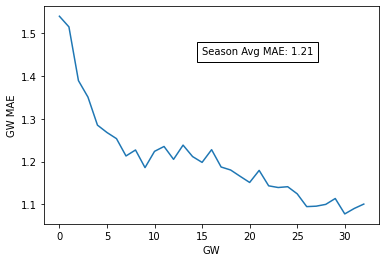

In [ ]:
plt.plot(results)
plt.ylabel('GW MAE')
plt.xlabel('GW')
plt.text(15, 1.45, 'Season Avg MAE: %.2f' % np.mean(results), bbox={'facecolor':'white', 'alpha':1, 'pad':5})
plt.show()

In [ ]:
results

1.2077307628862786